For our first taste of programming with Spark, we'll revisit the Lending Club dataset you first used earlier in the course. Instead of building a random forest though, we'll perform a logistic regression to determine the likelihood that someone will be approved for a loan.

In [1]:
CSV_PATH = "/home/ds/notebooks/datasets/LoanStats3d.csv"
APP_NAME = "Lending Club Random Forest Example"
SPARK_URL = "local[*]"
RANDOM_SEED = 141107
TRAINING_DATA_RATIO = 0.7
RF_NUM_TREES = 10
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName(APP_NAME) \
    .master(SPARK_URL) \
    .getOrCreate()

df = spark.read \
    .options(header = "true", inferschema = "true") \
    .csv(CSV_PATH)

df.drop('id', 'url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util', 'sub_grade', 'addr_state', 'desc').collect()

from pyspark.sql.types import IntegerType
from pyspark.sql.functions import regexp_replace
df=df.withColumn('int_rate', regexp_replace(df['int_rate'], "%", "").cast("float"))

print("Total number of rows: %d" % df.count())

Total number of rows: 421095


In [4]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: float (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string

In [5]:
df.select("loan_amnt", "int_rate", "loan_status").show(10)

+---------+--------+------------------+
|loan_amnt|int_rate|       loan_status|
+---------+--------+------------------+
|    12000|     9.8|        Fully Paid|
|    16000|   12.88|           Current|
|    30000|   15.77|        Fully Paid|
|    33600|   10.78|        Fully Paid|
|    25000|    7.49|        Fully Paid|
|    20000|   13.99|       Charged Off|
|    28000|   18.49|           Current|
|    12000|   10.78|        Fully Paid|
|    11550|   16.59|Late (31-120 days)|
|     2500|   17.27|           Current|
+---------+--------+------------------+
only showing top 10 rows



In [6]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="loan_status", outputCol="indexed_loan_status").fit(df)

([<matplotlib.axis.XTick at 0x7fbe10450da0>,
 <a list of 8 Text xticklabel objects>)

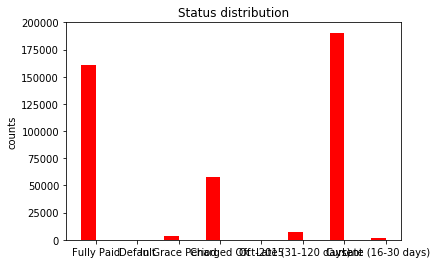

In [7]:
from matplotlib import pyplot as plt
import numpy as np
import functools
%matplotlib inline
 
statuses = df.groupBy('loan_status').count().collect()
categories = [i[0] for i in statuses]
counts = [i[1] for i in statuses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('Status distribution')
plt.xticks(ind + width/2., categories)

In [8]:
categoricals = [col[0] for col in df.dtypes if col[1] == 'string']

In [9]:
categoricals

['id',
 'member_id',
 'term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'earliest_cr_line',
 'inq_last_6mths',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'application_type',
 'annual_inc_joint',
 'verification_status_joint',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',
 'hardship_flag',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_loan_s